In [536]:
sc.stop()

### Initialize Spark instance

In [537]:
import findspark

findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

conf = (SparkConf().setMaster("spark://Rahuls-MBP:7077").setAppName("prod-reco-system").set("spark.executor.memory", "8g").set("spark.driver.memory","3g").set("spark.driver.maxResultSize","0").set("spark.storage.memoryFraction", "0.5"))

sc = SparkContext(conf = conf)


In [538]:
sc

<SparkContext master=spark://Rahuls-MBP:7077 appName=prod-reco-system>

In [342]:
import os
import pandas as pd
import numpy as np
from pyspark.sql import SQLContext


### Initialize data and paths

In [542]:
# category="Amazon_Instant_Video"
# category='Musical_Instruments'
# category='Apps_for_Android'
# category='Toys_and_Games'
# category='Cell_Phones_and_Accessories'
category='Electronics'
# category='Books'

In [543]:
#LOCAL
datasets_path = os.path.join('..', 'datasets')
models_path = os.path.join('..', 'models')

datasets_path_local = os.path.join('..', 'datasets')

In [544]:
#HDFS
datasets_path = "hdfs://192.168.1.6:9000/data/"
models_path = "hdfs://192.168.1.6:9000/models/"

datasets_path_local = os.path.join('..', 'datasets')

In [545]:
meta_data_file = os.path.join(datasets_path, 'meta_'+category+'.json')
meta_data_file_encoded = os.path.join(datasets_path, 'meta_'+category+'_encoded.csv')

meta_data_file_local = os.path.join(datasets_path_local, 'meta_'+category+'.json')
meta_data_file_encoded_local = os.path.join(datasets_path_local, 'meta_'+category+'_encoded.csv')

ratings_file = os.path.join(datasets_path, 'ratings_'+category+'.csv')
ratings_file_encoded = os.path.join(datasets_path, 'ratings_'+category+'_encoded.csv')
ratings_file_local = os.path.join(datasets_path_local, 'ratings_'+category+'.csv')



In [546]:
ratings_file_encoded

'hdfs://192.168.1.6:9000/data/ratings_Electronics_encoded.csv'

In [52]:
# ! hdfs dfs -mkdir /data
hdfs_cmd = "hdfs dfs -put -f "+meta_data_file_local+" /data/"
! $hdfs_cmd
hdfs_cmd = "hdfs dfs -put -f "+ratings_file_local+" /data/"
! $hdfs_cmd
! hdfs dfs -ls -t /data



18/05/28 02:17:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
18/05/28 02:18:08 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
18/05/28 02:18:14 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 25 items
-rw-r--r--   1 rahul supergroup  916259348 2018-05-28 02:18 /data/ratings_Books.csv
-rw-r--r--   1 rahul supergroup 2540618615 2018-05-28 02:18 /data/meta_Books.json
drwxr-xr-x   - rahul supergroup          0 2018-05-26 20:26 /data/ratings_Musical_Instruments_encoded.csv
-rw-r--r--   1 rahul supergroup   13329224 2018-05-26 20:25 /data/meta_Musical_Instruments_encoded.csv
-rw-r--r--   1 rahul supergroup   19875726 2018-05-26 20:24 /data/ratings_Musical_Instruments.csv
-rw-r--r--   1 rahul supergroup  102040366 2018-05-26 20:24 /data/me

### Process meta.json to meta-encoded.csv

In [350]:
sqlContext = SQLContext(sc)

print(meta_data_file)
df = sqlContext.read.json(meta_data_file)
# df.first()

df = df.select('asin','title','categories').withColumnRenamed('asin','prodId')

print(df.first())


from pyspark.ml.feature import StringIndexer

prodIdIndexer = StringIndexer(inputCol="prodId", outputCol="prodIdIndex",  handleInvalid='skip')
prodIdModel = prodIdIndexer.fit(df)
indexedDf = prodIdModel.transform(df)
# print(type(indexedDf.select('categories')))
# print(indexedDf.first())

prodIndexedDf = indexedDf.select('prodIdIndex','title','categories','prodId')

from pyspark.sql.types import IntegerType
from pyspark.sql.functions import regexp_replace

prodIndexedDf = prodIndexedDf.withColumn("prodIdIndex", prodIndexedDf["prodIdIndex"].cast(IntegerType()))
prodIndexedDf = prodIndexedDf.withColumn("title", regexp_replace(prodIndexedDf["title"], "[\\r\\n]", ""))

print(prodIndexedDf.first())

hdfs://192.168.1.6:9000/data/meta_Electronics.json
Row(prodId=u'0132793040', title=u'Kelby Training DVD: Mastering Blend Modes in Adobe Photoshop CS5 By Corey Barker', categories=[[u'Electronics', u'Computers & Accessories', u'Cables & Accessories', u'Monitor Accessories']])
Row(prodIdIndex=93026, title=u'Kelby Training DVD: Mastering Blend Modes in Adobe Photoshop CS5 By Corey Barker', categories=[[u'Electronics', u'Computers & Accessories', u'Cables & Accessories', u'Monitor Accessories']], prodId=u'0132793040')


In [351]:
prodIndexedDf.toPandas().to_csv(meta_data_file_encoded_local, header=True, index=False)

In [352]:
hdfs_cmd = "hdfs dfs -put -f "+meta_data_file_encoded_local+" /data/"
! $hdfs_cmd
! hdfs dfs -ls -t /data

18/05/29 19:42:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
18/05/29 19:42:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 26 items
-rw-r--r--   1 rahul supergroup   90331441 2018-05-29 19:42 /data/meta_Electronics_encoded.csv
drwxr-xr-x   - rahul supergroup          0 2018-05-29 00:13 /data/ratings_Musical_Instruments_encoded.csv
-rw-r--r--   1 rahul supergroup   13329224 2018-05-29 00:12 /data/meta_Musical_Instruments_encoded.csv
drwxr-xr-x   - rahul supergroup          0 2018-05-28 03:21 /data/ratings_Books_encoded.csv
-rw-r--r--   1 rahul supergroup  306860900 2018-05-28 02:55 /data/meta_Books_encoded.csv
-rw-r--r--   1 rahul supergroup  916259348 2018-05-28 02:18 /data/ratings_Books.csv
-rw-r--r--   1 rahul supergroup 2540618615 2018-05-28 02:18 /data/meta_Books.json
-rw-r--r--   1 rahul supergroup   1987

### Process ratings.csv to ratings-encoded.csv


In [353]:

df = sqlContext.read.csv(ratings_file)
# print(df.first())

df = df.withColumnRenamed('_c0','userId').withColumnRenamed('_c1','prodId').withColumnRenamed('_c2','rating').withColumnRenamed('_c3','timestamp')

from pyspark.ml.feature import StringIndexer

prodIdIndexedDf = prodIdModel.transform(df)
# print(prodIdIndexedDf.first())

useridIndexer = StringIndexer(inputCol="userId", outputCol="userIdIndex", handleInvalid='skip')
userIdModel = useridIndexer.fit(prodIdIndexedDf)
useridIndexedDf = userIdModel.transform(prodIdIndexedDf)

# print(useridIndexedDf.first())

useridIndexedDf = useridIndexedDf.withColumn("userIdIndex", useridIndexedDf["userIdIndex"].cast(IntegerType()))
useridIndexedDf = useridIndexedDf.withColumn("prodIdIndex", useridIndexedDf["prodIdIndex"].cast(IntegerType()))

finalIndexedDf = useridIndexedDf.select('userIdIndex','prodIdIndex','rating','userId','prodId')
print(finalIndexedDf.first())
print(finalIndexedDf.count())

Row(userIdIndex=849668, prodIdIndex=93026, rating=u'5.0', userId=u'AKM1MP6P0OYPR', prodId=u'0132793040')
6584243


In [354]:
finalIndexedDf.write.mode('overwrite').format("com.databricks.spark.csv").option("header", "true").save(ratings_file_encoded)

In [355]:
! hdfs dfs -ls -t /data

18/05/29 19:49:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 26 items
drwxr-xr-x   - rahul supergroup          0 2018-05-29 19:49 /data/ratings_Electronics_encoded.csv
-rw-r--r--   1 rahul supergroup   90331441 2018-05-29 19:42 /data/meta_Electronics_encoded.csv
drwxr-xr-x   - rahul supergroup          0 2018-05-29 00:13 /data/ratings_Musical_Instruments_encoded.csv
-rw-r--r--   1 rahul supergroup   13329224 2018-05-29 00:12 /data/meta_Musical_Instruments_encoded.csv
drwxr-xr-x   - rahul supergroup          0 2018-05-28 03:21 /data/ratings_Books_encoded.csv
-rw-r--r--   1 rahul supergroup  306860900 2018-05-28 02:55 /data/meta_Books_encoded.csv
-rw-r--r--   1 rahul supergroup  916259348 2018-05-28 02:18 /data/ratings_Books.csv
-rw-r--r--   1 rahul supergroup 2540618615 2018-05-28 02:18 /data/meta_Books.json
-rw-r--r--   1 rahul supergroup   19875726 2018-05-26 20:24 /data/ratings_Musical_Instru

### Load CSV data from existing files

In [547]:
ratings_raw_data = sc.textFile(ratings_file_encoded)
ratings_raw_data_header = ratings_raw_data.take(1)[0]

In [548]:
ratings_data = ratings_raw_data.filter(lambda line: line!=ratings_raw_data_header).map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),int(tokens[1]),float(tokens[2]))).cache()

In [549]:
ratings_count = ratings_data.count()
print(ratings_count)
print(ratings_data.take(3))
# type(ratings_data.first()[0])

6584243
[(849668, 93026, 5.0), (263499, 165519, 5.0), (1266909, 86550, 1.0)]


In [550]:
ratings_id_ratings = (ratings_data.map(lambda x: (int(x[0]), float(x[2]))).groupByKey())
users_count = ratings_id_ratings.count()
ratings_per_user_ratio = float(ratings_count)/users_count 
print(ratings_count)
print(users_count)
print(ratings_per_user_ratio)
# print(ratings_id_ratings.take(3))


6584243
3697953
1.78051019037


In [551]:
data_distribution = ratings_data.map(lambda x: int(math.floor(float(x[2]))))
print(data_distribution.take(10))
print(data_distribution.count())

count_dict = dict()
count_sum = 0
for i in range(1,6):
    data_distribution_group = data_distribution.filter(lambda x: x==i)
    count_i = data_distribution_group.count()
    count_sum += count_i
    count_dict[i] = count_i
    print(i, count_i)
print(count_sum)


[5, 5, 1, 3, 1, 3, 1, 5, 1, 1]
6584243
(1, 769360)
(2, 384884)
(3, 532423)
(4, 1241210)
(5, 3656366)
6584243


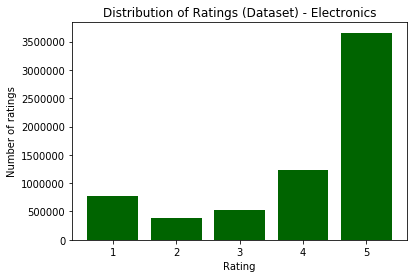

In [552]:
import matplotlib.pyplot as plt
plt.bar(list(count_dict.keys()), count_dict.values(), color='darkgreen')
plt.xlabel("Rating")
plt.ylabel("Number of ratings")
plt.title("Distribution of Ratings (Dataset) - "+str(category))
plt.show()

### Load product meta_(category)_encoded.csv


In [553]:
product_meta_data_raw = sc.textFile(meta_data_file_encoded)
product_meta_data_raw_header = product_meta_data_raw.take(1)[0]

product_meta_data = product_meta_data_raw.filter(lambda line: line!=product_meta_data_raw_header).map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),tokens[1], str(tokens[2]))).cache()

# print(product_meta_data_raw.take(3))
print(product_meta_data.count())
print(product_meta_data.take(3))

427097
[(93026, u'Kelby Training DVD: Mastering Blend Modes in Adobe Photoshop CS5 By Corey Barker', '"[[u\'Electronics\''), (165519, u'Kelby Training DVD: Adobe Photoshop CS5 Crash Course By Matt Kloskowski', '"[[u\'Electronics\''), (86550, u'Digital Organizer and Messenger', '"[[u\'Electronics\'')]


In [554]:
training_set, validation_set, test_set = ratings_data.randomSplit([6, 2, 2], seed=0L)
validation_set_pred = validation_set.map(lambda x: (x[0], x[1]))
test_set_pred = test_set.map(lambda x: (x[0], x[1]))

### TRAIN THE MODEL

In [495]:
import time
from pyspark.mllib.recommendation import ALS
import math

seed = 5L
iterations = 20
regularization_parameter = 0.5
ranks = [8]
errors = [0] * len(ranks)
err = 0
tolerance = 0.02

min_error = float('inf')
best_rank = -1
best_iteration = -1
for rank in ranks:
    start = time.time()

    model = ALS.train(training_set, rank, seed=seed, iterations=iterations,lambda_=regularization_parameter)
    predictions = model.predictAll(validation_set_pred).map(lambda r: ((r[0], r[1]), r[2]))
    ratings_predictions = validation_set.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(ratings_predictions.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors[err] = error
    err += 1
    print('Rank %s: RMSE = %s' % (rank, error))
    if error < min_error:
        min_error = error
        best_rank = rank
        
    end = time.time()
    print('Time required: %s' % str(end - start))
print('Best model rank: %s' % best_rank)


Rank 8: RMSE = 1.63806409395
Time required: 1791.45815802
Best model rank: 8


### Optimize Regularization parameter


In [325]:
import time
from pyspark.mllib.recommendation import ALS
import math

seed = 5L
iterations = 20
regularization_parameters = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
rank = 8
errors = [0] * len(regularization_parameters)
err = 0
tolerance = 0.02

min_error = float('inf')
best_reg_param = -1
best_iteration = -1
for regularization_parameter in regularization_parameters:
    start = time.time()

    model = ALS.train(training_set, rank, seed=seed, iterations=iterations,lambda_=regularization_parameter)
    predictions = model.predictAll(validation_set_pred).map(lambda r: ((r[0], r[1]), r[2]))
    ratings_predictions = validation_set.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(ratings_predictions.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors[err] = error
    err += 1
    print('RP %s: RMSE = %s' % (regularization_parameter, error))
    if error < min_error:
        min_error = error
        best_reg_param = regularization_parameter
        
    end = time.time()
    print('Time required: %s' % str(end - start))
print('Best model rank: %s' % best_reg_param)


RP 0.001: RMSE = 7.44214225534
Time required: 26.4670288563
RP 0.005: RMSE = 5.7002634169
Time required: 22.3995189667
RP 0.01: RMSE = 5.20962179875
Time required: 29.6096789837
RP 0.05: RMSE = 4.28086486979
Time required: 22.1840929985
RP 0.1: RMSE = 3.70143706227
Time required: 20.4284348488
RP 0.5: RMSE = 3.06108986226
Time required: 21.7208747864
RP 1.0: RMSE = 3.12001839469
Time required: 19.3582651615
RP 5.0: RMSE = 4.47756841721
Time required: 20.6618559361
RP 10.0: RMSE = 4.47757492448
Time required: 21.6949081421
RP 50.0: RMSE = 4.47757492448
Time required: 18.1499230862
Best model rank: 0.5


### LOAD EXISTING MODEL

In [556]:
! hdfs dfs -ls -t /models

18/05/30 01:02:06 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 5 items
drwxr-xr-x   - rahul supergroup          0 2018-05-30 00:23 /models/model_Books_8
drwxr-xr-x   - rahul supergroup          0 2018-05-29 20:16 /models/model_Electronics_8
drwxr-xr-x   - rahul supergroup          0 2018-05-29 00:56 /models/model_Musical_Instruments_64
drwxr-xr-x   - rahul supergroup          0 2018-05-26 20:36 /models/model_Musical_Instruments_8
drwxr-xr-x   - rahul supergroup          0 2018-05-26 16:08 /models/model_Cell_Phones_and_Accessories_8


In [557]:
from pyspark.mllib.recommendation import MatrixFactorizationModel

model_name = "model_"+str(category)+"_"+str(8)
model_path = os.path.join(models_path, model_name)

model = MatrixFactorizationModel.load(sc, model_path)

### TEST MODEL

In [558]:
start = time.time()
predictions = model.predictAll(test_set_pred).map(lambda r: ((r[0], r[1]), r[2]))
ratings_predictions = test_set.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(ratings_predictions.map(lambda r: (r[1][0] - r[1][1])**2).mean())
end = time.time()    
print 'For testing data the RMSE is %s' % (error)
print('Time required: %s' % str(end - start))


For testing data the RMSE is 1.81602524824
Time required: 27.3252410889


In [559]:
predictions.take(5)

[((170792, 91680), 3.9691310364186223),
 ((386896, 348712), 2.6288057284293873),
 ((1005400, 124660), 3.4531108164685413),
 ((988056, 78375), 4.056259395822714),
 ((196224, 239285), 3.6757123933378515)]

In [560]:
ratings_predictions.take(5)

[((263259, 133999), (5.0, 2.4358965699487687)),
 ((896511, 83283), (1.0, 3.2342934307949154)),
 ((2719, 222819), (5.0, 4.099493528103354)),
 ((404739, 352343), (5.0, 0.6393902736572643)),
 ((729142, 27996), (5.0, -0.7395116837819558))]

In [562]:
actual_data_distribution = ratings_predictions.map(lambda x: int((float(x[1][0]))))
print(actual_data_distribution.take(10))
print(actual_data_distribution.count())

actual_count_dict = dict()
actual_count_sum = 0
for i in range(1,6):
    actual_data_distribution_group = actual_data_distribution.filter(lambda x: x==i)
    count_i = actual_data_distribution_group.count()
    actual_count_sum += count_i
    actual_count_dict[i] = count_i
    print(i, count_i)
print(actual_count_sum)

[5, 1, 5, 5, 5, 5, 5, 4, 1, 5]
650054
(1, 54777)
(2, 34817)
(3, 54905)
(4, 128220)
(5, 377335)
650054


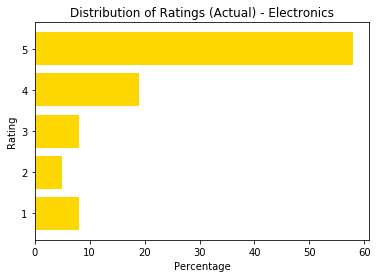

In [563]:
import matplotlib.pyplot as plt
values = actual_count_dict.values()
plot_values = (x*100/actual_count_sum for x in values)
plt.barh(list(actual_count_dict.keys()), list(plot_values), color='gold')
plt.ylabel("Rating")
plt.xlabel("Percentage")
plt.title("Distribution of Ratings (Actual) - "+str(category))
plt.show()

In [564]:
prediction_data_distribution = ratings_predictions.map(lambda x: int(math.ceil(float(x[1][1]))))
print(prediction_data_distribution.take(10))
print(prediction_data_distribution.count())

prediction_count_dict = dict()
prediction_count_sum = 0
for i in range(1,6):
    prediction_data_distribution_group = prediction_data_distribution.filter(lambda x: x==i)
    count_i = prediction_data_distribution_group.count()
    prediction_count_sum += count_i
    prediction_count_dict[i] = count_i
    print(i, count_i)
print(prediction_count_sum)

[3, 4, 5, 1, 0, 5, 4, 3, 1, 3]
650054
(1, 39340)
(2, 44042)
(3, 110128)
(4, 272227)
(5, 168052)
633789


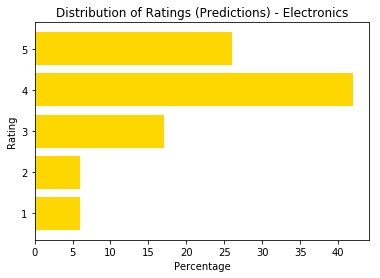

In [565]:
import matplotlib.pyplot as plt
values = prediction_count_dict.values()
plot_values = (x*100/prediction_count_sum for x in values)
plt.barh(list(prediction_count_dict.keys()), list(plot_values), color='gold')
plt.ylabel("Rating")
plt.xlabel("Percentage")
plt.title("Distribution of Ratings (Predictions) - "+str(category))
plt.show()

In [567]:
product_titles = product_meta_data.map(lambda x: str(x[1]))
# print(product_titles.count())
print(product_meta_data.take(3))
# print(product_titles.take(3))
print(ratings_data.take(3))

[(93026, u'Kelby Training DVD: Mastering Blend Modes in Adobe Photoshop CS5 By Corey Barker', '"[[u\'Electronics\''), (165519, u'Kelby Training DVD: Adobe Photoshop CS5 Crash Course By Matt Kloskowski', '"[[u\'Electronics\''), (86550, u'Digital Organizer and Messenger', '"[[u\'Electronics\'')]
[(849668, 93026, 5.0), (263499, 165519, 5.0), (1266909, 86550, 1.0)]


In [568]:
def get_counts_and_averages(ID_and_ratings_tuple):
    nratings = len(ID_and_ratings_tuple[1])
    return ID_and_ratings_tuple[0], (nratings, float(sum(x for x in ID_and_ratings_tuple[1]))/nratings)

product_id_ratings = (ratings_data.map(lambda x: (int(x[1]), float(x[2]))).groupByKey())
# print(product_id_ratings.take(3))
product_id_rating_count_avg = product_id_ratings.map(get_counts_and_averages)
# [0] = prodId, [1] = ([0] = count of ratings, [1] = avg of ratings)
product_rating_counts = product_id_rating_count_avg.map(lambda x: (x[0], x[1][0]))
print(product_rating_counts.take(5))

[(131072, 2), (393216, 1), (0, 5), (131080, 2), (16, 15)]


In [741]:
target_user_id = 10000
target_user_ratings = ratings_data.filter(lambda x: int(x[0]) == target_user_id)
print(target_user_ratings.count())
print(target_user_ratings.take(3))
target_user_ratings_ids = target_user_ratings.map(lambda x: x[1]) 
target_user_ids_title = target_user_ratings.map(lambda x: (x[1],x[2])).join(product_meta_data)
# print(target_user_ratings_ids.take(3))
print(target_user_ids_title.take(3))
target_user_unrated_products = (product_meta_data.map(lambda x: (target_user_id, x[0])))
# print(target_user_unrated_products.take(3))

19
[(10000, 6466, 4.0), (10000, 285558, 4.0), (10000, 123942, 4.0)]
[(146110, (4.0, u'CowboyStudio Professional Neoprene Neck Strap Neckstrap for NIKON Camera')), (314880, (5.0, u'"Wacom Intuos3 4x5 Pen Tablet')), (318991, (5.0, u'Klipsch RCX4 Reference Center Channel Speaker'))]


In [742]:
target_user_predictions = model.predictAll(target_user_unrated_products)

In [743]:
print(product_meta_data.count())
print(target_user_predictions.count())
print(target_user_predictions.take(3))

427097
332580
[Rating(user=10000, product=257320, rating=3.1137452317653573), Rating(user=10000, product=23776, rating=1.2625907278107662), Rating(user=10000, product=307248, rating=1.760473646492331)]


### Getting top recommendations


In [744]:
target_user_predictions_2 = target_user_predictions.map(lambda x: (x.product, x.rating))

target_user_predictions_titles_counts = target_user_predictions_2.join(product_meta_data).join(product_rating_counts)
print(target_user_predictions_titles_counts.count())
print(target_user_predictions_titles_counts.take(3))

332580
[(0, ((3.331943515026759, u'DROK DC Converter 12V to 5V 3A Car USB Charger Power Supply for iPhone iPad Phone In Vehicle DVR Recorder'), 5)), (131076, ((0.9299691689928007, u'Pioneer DEH-6010MP In-Dash Single DIN MP3/WMA/WAV/CD Tuner AM/FM with Rotary Commander and 2 RCA pre-outs AUX &amp; Remote'), 3)), (262152, ((2.6734830248002517, u'4-Port USB Peripheral Sharing Device'), 1))]


In [745]:
target_user_predictions_titles_counts = target_user_predictions_titles_counts.map(lambda r: (r[1][0][1], r[1][0][0], r[1][1], r[0]))

In [746]:
top_product_recommendations = target_user_predictions_titles_counts.filter(lambda r: r[2]>=25).takeOrdered(10, key=lambda x: -x[1])
user_rated_products = target_user_ids_title.takeOrdered(20, key=lambda x: -x[1][0])

In [747]:
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(user_rated_products)

,0,1
0,314880,"(5.0, ""Wacom Intuos3 4x5 Pen Tablet)"
1,318991,"(5.0, Klipsch RCX4 Reference Center Channel Speaker)"
2,259121,"(5.0, Tamrac 3536 Express 6 Camera Bag -Black)"
3,272012,"(5.0, ""SanDisk Ultra 64GB MicroSDXC Class 10 UHS Memory Card Speed Up To 30MB/s With Adapter)"
4,220222,"(5.0, Klipsch RB-41 II Bookshelf Speaker - Black - Pair)"
5,235673,"(5.0, DVI to HDMI Cable 6ft Male-Male)"
6,146110,"(4.0, CowboyStudio Professional Neoprene Neck Strap Neckstrap for NIKON Camera)"
7,291542,"(4.0, Apple 4 GB iPod nano - White (1G) (Discontinued by Manufacturer))"
8,123942,"(4.0, Philips MCM530 150-Watt Micro Shelf System with 5-Disc CD/MP3 Changer and Digital AM/FM Tuner (Discontinued by Manufacturer))"
9,47694,"(4.0, Genius Wireless Energy Mouse with Built-In 2700mAh Powerbank for iOS and Android Smartphone Devices)"


In [748]:
pd.DataFrame(top_product_recommendations)

,0,1,2,3
0,Pentax K2000 10.2MP Digital SLR Camera with 18-55mm f/3.5-5.6 DA L Lens and AF200FG Flash,4.018570,25,211074
1,JAVOedge Cherry Blossom Flip Style Case for the Barnes &amp; Noble Nook (Ocean Blue) - First Generation,3.980742,26,273396
2,Panasonic PV-GS500 4MP 3CCD MiniDV Camcorder with 12x Optical Image Stabilized Zoom,3.978618,48,292941
3,Olympus EX-25mm Macro Extension Tube for Olympus Digital SLR Cameras,3.944165,32,408677
4,"""EasyAcc &reg; Portable Adjust Stand Docks Holder Docking Station for all 4-10 inch Smart phone/E-reader/Tablet:iPad",3.939665,74,21806
5,Olympus VF-4 ViewFinder (Black),3.936197,25,105768
6,"""SMDV RFN-4s Slim Wireless Remote Shutter Cable Release",3.933766,49,426807
7,,3.933062,26,202423
8,"""Pioneer AVH-P6300BT 7-Inch In-Dash DVD A/V Receiver with iPod/iPhone Control",3.930538,41,425920
9,Coolerguys 120x120x25mm USB Fan with Grill,3.926401,82,185599


### SAVE THE MODEL

In [526]:
from pyspark.mllib.recommendation import MatrixFactorizationModel

model_name = "model_"+str(category)+"_"+str(best_rank)
model_path = os.path.join(models_path, model_name)

model.save(sc, model_path)


In [527]:
! hdfs dfs -ls -t /models

18/05/30 00:50:41 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 5 items
drwxr-xr-x   - rahul supergroup          0 2018-05-30 00:23 /models/model_Books_8
drwxr-xr-x   - rahul supergroup          0 2018-05-29 20:16 /models/model_Electronics_8
drwxr-xr-x   - rahul supergroup          0 2018-05-29 00:56 /models/model_Musical_Instruments_64
drwxr-xr-x   - rahul supergroup          0 2018-05-26 20:36 /models/model_Musical_Instruments_8
drwxr-xr-x   - rahul supergroup          0 2018-05-26 16:08 /models/model_Cell_Phones_and_Accessories_8


##### DELETE EXISTING MODELS

In [ ]:
model_path

In [524]:
# hdfs_cmd="hdfs dfs -rm -r -f "+str(model_path)
# ! $hdfs_cmd

18/05/30 00:22:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hdfs://192.168.1.6:9000/models/model_Books_8


### END OF NOTEBOOK